In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import os
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import cv2

IMAGE_SIZE = 400

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def generate_image(digits, image_size=IMAGE_SIZE):
    if len(digits) != 4:
        raise ValueError('Необходимо 4 цифры')

    font_size = image_size // 2
    image = Image.new('RGB', (image_size, image_size), color='white')
    draw = ImageDraw.Draw(image)

    font = ImageFont.load_default(font_size)
    # font = ImageFont.truetype('./drive/MyDrive/Диплом/ARIAL.TTF', size=font_size)
    offset_y = font.font.getsize('8')[-1][-1]

    x1 = (image_size // 10)
    y1 = 0 - (offset_y // 2)
    x2 = (image_size // 10) * 6
    y2 = (image_size // 2) - (offset_y // 2)

    draw.text((x1, y1), digits[0], font=font, fill="black")
    draw.text((x2, y1), digits[1], font=font, fill="black")
    draw.text((x1, y2), digits[2], font=font, fill="black")
    draw.text((x2, y2), digits[3], font=font, fill="black")

    return image

In [ ]:
random_digits = [str(random.randint(0, 9)) for _ in range(4)]
print(random_digits)
image = generate_image(random_digits)
# image.save(f'digit_image.png')

['5', '9', '9', '9']


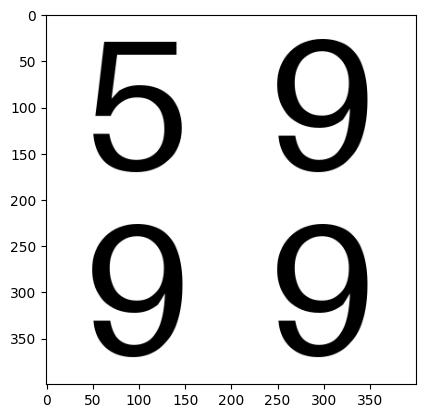

In [ ]:
img_array = np.array(image)
plt.imshow(img_array)
plt.show()

## 1. Горизонтальные полосы

In [ ]:
digits = [str(random.randint(0, 9)) for _ in range(4)]
print(digits)
img_array = np.array(generate_image(digits))
for i in range(0, 400, 50):
    if i % 100 == 50:
        img_array[i: i + 50, :] = np.concatenate((img_array[i: i + 50, 10:], np.full((50, 10, 3), 255, dtype=int)), axis=1)
    else:
        img_array[i: i + 50, :] = np.concatenate((np.full((50, 10, 3), 255, dtype=int), img_array[i: i + 50, :-10]), axis=1)

['4', '9', '0', '3']
40 240 -26 174


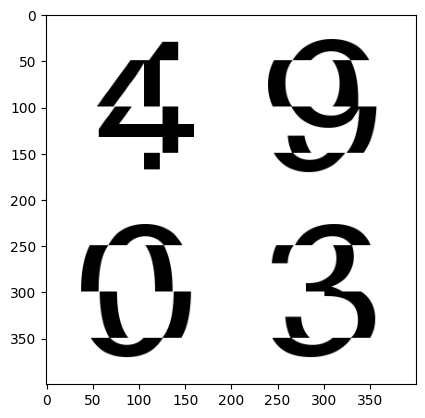

In [ ]:
plt.imshow(img_array)
plt.show()

## 2. Вертикальные полосы

In [ ]:
img_array = np.array(generate_image([str(random.randint(0, 9)) for _ in range(4)]))
column_width = 20
for i in range(0, IMAGE_SIZE, column_width):
    if (i // column_width) % 2 == 0:
        img_array[:, i: i + column_width] = np.concatenate((img_array[10:, i: i + column_width], np.full((10, column_width, 3), 255, dtype=int)), axis=0)
    else:
        img_array[:, i: i + column_width] = np.concatenate((np.full((10, column_width, 3), 255, dtype=int), img_array[:-10, i: i + column_width]), axis=0)

40 240 -26 174


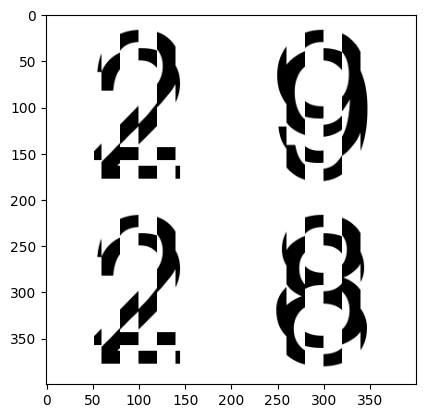

In [ ]:
plt.imshow(img_array)
plt.show()

## 3. Волны

In [ ]:
def wave_transform(img_array, wave_len=40, step=2, border=False):
    new_img = np.zeros(img_array.shape, dtype='uint8')
    counter = step
    flag = True
    for i in range(0, IMAGE_SIZE, 2):
        if counter == step:
            flag = True
        if counter == wave_len:
            flag = False
        counter = counter + step if flag else counter - step
        new_img[i:i + 2, :] = np.concatenate((np.full((2, counter, 3), 255, dtype='uint8'), img_array[i:i + 2, :-counter]), axis=1)
    if border:
        height, width, channels = new_img.shape
        border_width = 10
        new_height = height + 2 * border_width
        new_width = width + 2 * border_width
        bordered_image = np.zeros((new_height, new_width, channels), dtype=np.uint8)

        bordered_image[border_width:border_width + height, border_width:border_width + width, :] = new_img
        new_img = bordered_image
    return new_img

['0', '3', '6', '8']


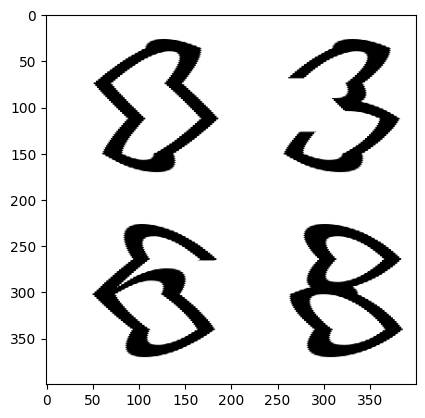

In [ ]:
digits = [str(random.randint(0, 9)) for _ in range(4)]
print(digits)
img_array = np.array(generate_image(digits))
img_array = wave_transform(img_array)
plt.imshow(img_array)
plt.show()

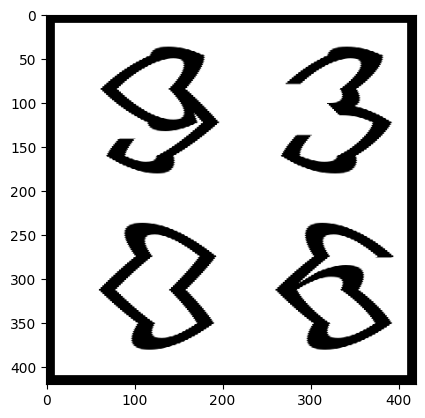

In [ ]:
img_array = np.array(generate_image(['9', '3', '0', '6']))
img_array = wave_transform(img_array, border=True)
plt.imshow(img_array)
plt.show()

In [ ]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.05, p=1.0, fill=255)
affine_transfomer = v2.RandomAffine(degrees=(-15, 15), scale=(0.9, 0.9), fill=255)
rotate_transformer = v2.RandomRotation(degrees=(-15, 15),expand=True, fill=255)

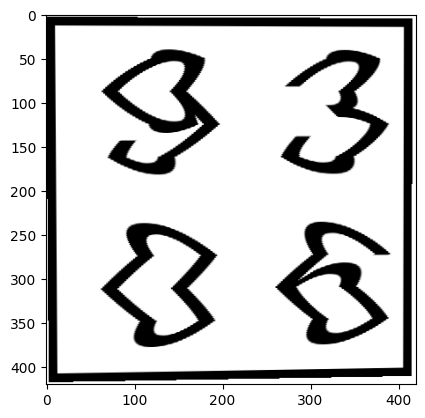

In [ ]:
plt.imshow(perspective_transformer(Image.fromarray(img_array)))
plt.show()

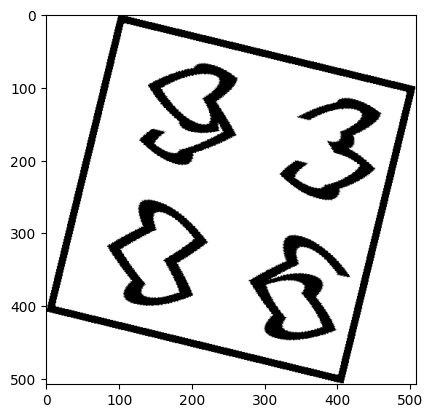

In [ ]:
plt.imshow(rotate_transformer(Image.fromarray(img_array)))
plt.show()

## Создание датасета

In [ ]:
!pip install augraphy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 15.8 MB/s eta 0:00:00


In [ ]:
from augraphy.augmentations import Moire
from skimage.util import random_noise

In [ ]:
if not os.path.exists('./dataset_with_border'):
    os.makedirs('./dataset_with_border')

In [ ]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.05, fill=255)
affine_transfomer = v2.RandomAffine(degrees=(-12, 12), scale=(0.7, 0.9), fill=255, translate=(0.08, 0.08))
rotate_transformer = v2.RandomRotation(degrees=(-10, 10),expand=True, fill=255)
moire = Moire(moire_density = (1,3), moire_blend_alpha = 0.9)


def add_moire(image, moire):
    moire_image = moire(np.array(Image.new('RGB', (image.shape[0], image.shape[0]), color='white')))
    gray_foreground = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_foreground, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    foreground_extracted = cv2.bitwise_and(image, moire_image, mask=mask)
    mask_inv = cv2.bitwise_not(mask)
    background_extracted = cv2.bitwise_and(image, moire_image, mask=mask_inv)
    final_image = cv2.add(foreground_extracted, background_extracted)
    final_image = np.where((final_image > 120) & (final_image < 210), 100, final_image)
    return np.clip(cv2.blur(random_noise(final_image, var=0.002), (2,2)), 0, 1)


def save_image(img, path):
    image = cv2.resize(np.array(img), (200, 200), interpolation=cv2.INTER_LANCZOS4)
    if image.dtype == 'float64':
        image = np.clip(image, 0, 1)
    plt.imsave(path, image)


def add_random_blur(img):
    n = random.randint(3, 7)
    return cv2.blur(img,(n, n))

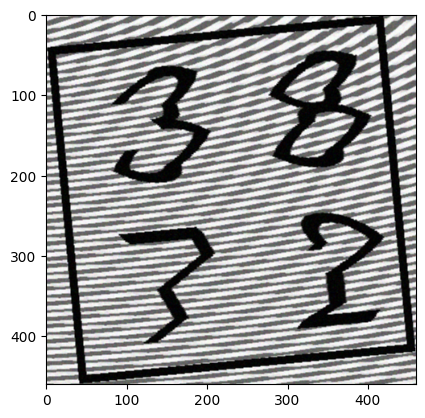

In [ ]:
digits = [str(random.randint(0, 9)) for _ in range(4)]
img = np.array(generate_image(digits))
transformed_img = wave_transform(img, border=True)
plt.imshow(add_moire(np.array(rotate_transformer(Image.fromarray(transformed_img))), moire), cmap='gray')

In [ ]:
# from IPython.display import display, clear_output

# def gen_dataset(out_path, transform, affine_transfomer, perspective_transformer, add_moire):
#     counter = dict()
#     digits_set = set()
#     for i in range(8000):
#         clear_output(wait=True)
#         digits = [str(random.randint(0, 9)) for _ in range(4)]
#         if ''.join(digits) in digits_set:
#             continue
#         digits_set.add(''.join(digits))

#         for idx, digit in enumerate(digits):
#             key = f'{digit}_1' if idx < 2 else f'{digit}_2'
#             if key not in counter:
#                 counter[key] = 0
#             counter[key] += 1

#         img = np.array(generate_image(digits))
#         transformed_img = transform(img)
#         plt.imsave(f'./{out_path}/{"".join(digits)}_1.jpg', transformed_img)

#         perspective_img = np.array(perspective_transformer(Image.fromarray(transformed_img)))
#         plt.imsave(f'./{out_path}/{"".join(digits)}_2.jpg', perspective_img)

#         affine_img = np.array(affine_transfomer(Image.fromarray(transformed_img)))
#         plt.imsave(f'./{out_path}/{"".join(digits)}_3.jpg', affine_img)
#         affine_img1 = np.array(affine_transfomer(Image.fromarray(transformed_img)))
#         plt.imsave(f'./{out_path}/{"".join(digits)}_4.jpg', affine_img1)
#         # transformed_img = random_noise(transformed_img, var=0.002)
#         for idx, image in enumerate([transformed_img, perspective_img, affine_img, affine_img1]):
#             moire_img = add_moire(image, moire)
#             plt.imsave(f'./{out_path}/{"".join(digits)}_{5 + idx}.jpg', moire_img)
#         display(len(digits_set))
#     print(len(counter.keys()), len(digits_set), 'images count:',  8 * len(digits_set))

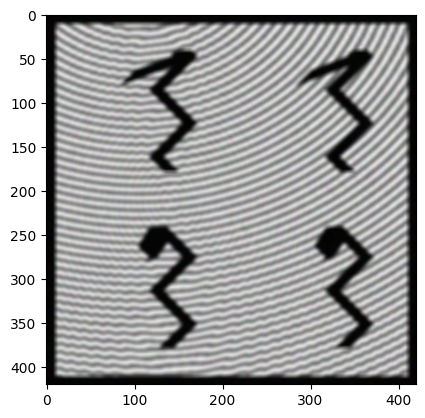

In [ ]:
plt.imshow(add_random_blur(add_moire(np.array(wave_transform(np.array(generate_image(['1', '1', '1', '1'])), border=True)), moire)) )

In [ ]:
from IPython.display import display, clear_output

def gen_dataset(out_path, transform, rotate_transformer, perspective_transformer, add_moire, border=False):
    blured = 0
    counter = dict()
    digits_set = set()
    for i in range(8000):
        clear_output(wait=True)
        digits = [str(random.randint(0, 9)) for _ in range(4)]
        if ''.join(digits) in digits_set:
            continue
        digits_set.add(''.join(digits))

        for idx, digit in enumerate(digits):
            key = f'{digit}_1' if idx < 2 else f'{digit}_2'
            if key not in counter:
                counter[key] = 0
            counter[key] += 1

        img = np.array(generate_image(digits))
        transformed_img = transform(img, border=border)
        transformed_images = []
        transformed_images.append(transformed_img)
        transformed_images.append(np.array(perspective_transformer(Image.fromarray(transformed_img))))
        transformed_images.append(np.array(rotate_transformer(Image.fromarray(transformed_img))))
        transformed_images.append(np.array(rotate_transformer(Image.fromarray(transformed_img))))
        transformed_images.append(np.array(rotate_transformer(Image.fromarray(transformed_img))))

        for i in range(len(transformed_images) * 2):
            is_blured = random.randint(0, 1)
            if i >= len(transformed_images):
                moire_image = add_moire(transformed_images[i - len(transformed_images)], moire)
                moire_image = add_random_blur(moire_image) if is_blured else moire_image
                save_image(moire_image, f'{out_path}/{"".join(digits)}_{i}.jpg')
            else:
                save_image(
                    add_random_blur(transformed_images[i]) if is_blured else transformed_images[i],
                    f'{out_path}/{"".join(digits)}_{i}.jpg'
                )
            if is_blured:
                blured += 1

        # transformed_img = random_noise(transformed_img, var=0.002)

        display(f'unique digits {len(digits_set)}, blured {blured}, all count {len(digits_set) * 10}')

In [ ]:
gen_dataset('./dataset_with_border', wave_transform, rotate_transformer, perspective_transformer, add_moire, border=True)

'unique digits 5498, blured 27446, all count 54980'

In [ ]:
!zip -r dataset_with_border.zip ./dataset_with_border

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: dataset_with_border/5659_7.jpg (deflated 1%)
  adding: dataset_with_border/3603_1.jpg (deflated 18%)
  adding: dataset_with_border/5099_9.jpg (deflated 1%)
  adding: dataset_with_border/2591_6.jpg (deflated 1%)
  adding: dataset_with_border/4084_9.jpg (deflated 1%)
  adding: dataset_with_border/8702_7.jpg (deflated 1%)
  adding: dataset_with_border/5535_8.jpg (deflated 1%)
  adding: dataset_with_border/1192_5.jpg (deflated 1%)
  adding: dataset_with_border/6035_5.jpg (deflated 2%)
  adding: dataset_with_border/5152_6.jpg (deflated 2%)
  adding: dataset_with_border/4304_5.jpg (deflated 1%)
  adding: dataset_with_border/5621_2.jpg (deflated 4%)
  adding: dataset_with_border/0703_1.jpg (deflated 17%)
  adding: dataset_with_border/7992_7.jpg (deflated 2%)
  adding: dataset_with_border/1946_7.jpg (deflated 1%)
  adding: dataset_with_border/9488_1.jpg (deflated 5%)
  adding: dataset_with_border/1647_7.jpg (deflated

In [ ]:
!cp ./dataset_with_border.zip ./drive/MyDrive/Диплом/

## Чтение датасета

In [ ]:
# !unzip ./drive/MyDrive/Диплом/dataset.zip
!unzip ./drive/MyDrive/Диплом/dataset_with_border.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset_with_border/5659_7.jpg  
  inflating: dataset_with_border/3603_1.jpg  
  inflating: dataset_with_border/5099_9.jpg  
  inflating: dataset_with_border/2591_6.jpg  
  inflating: dataset_with_border/4084_9.jpg  
  inflating: dataset_with_border/8702_7.jpg  
  inflating: dataset_with_border/5535_8.jpg  
  inflating: dataset_with_border/1192_5.jpg  
  inflating: dataset_with_border/6035_5.jpg  
  inflating: dataset_with_border/5152_6.jpg  
  inflating: dataset_with_border/4304_5.jpg  
  inflating: dataset_with_border/5621_2.jpg  
  inflating: dataset_with_border/0703_1.jpg  
  inflating: dataset_with_border/7992_7.jpg  
  inflating: dataset_with_border/1946_7.jpg  
  inflating: dataset_with_border/9488_1.jpg  
  inflating: dataset_with_border/1647_7.jpg  
  inflating: dataset_with_border/2579_3.jpg  
  inflating: dataset_with_border/6803_6.jpg  
  inflating: dataset_with_border/0137_7.jpg  
  inflating:

In [ ]:
ds_path = './dataset_with_border'

In [ ]:
images = []
labels = []

In [ ]:
for img_name in os.listdir(ds_path):
    img = Image.open(f'{ds_path}/{img_name}')
    images.append(
        cv2.cvtColor(
            cv2.resize(np.array(img), (200, 200), interpolation=cv2.INTER_LANCZOS4),
            cv2.COLOR_BGR2GRAY
        )
    )
    labels.append(np.array(tuple(map(int, img_name[:4]))))
images = np.array(images)
labels = np.array(labels)

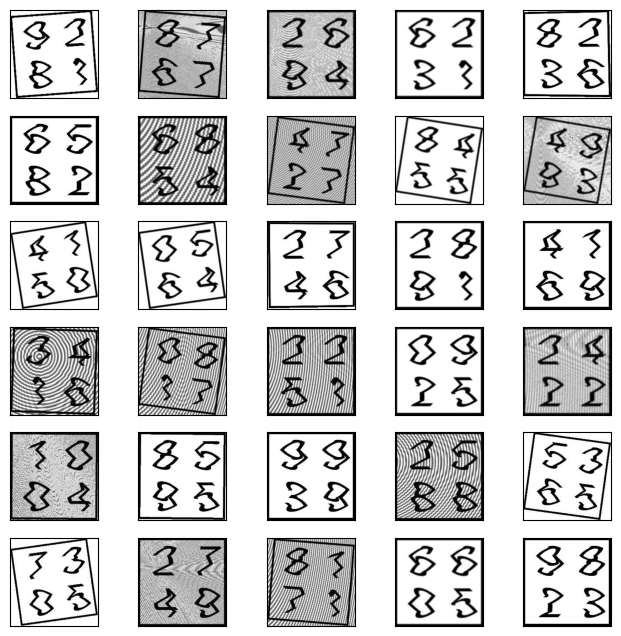

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(8, 8))
for i in range(30):
    ax = axs[i // 5, i % 5]
    ax.imshow(images[random.randint(0, len(images))],cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
len(labels), len(np.unique(labels, axis=0))

(54980, 5498)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

In [ ]:
def split_data(X, y, test_size=0.25, random_state=42):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    uniq_labels_count = len(np.unique(y, axis=0))
    selected_labels = set()
    n = np.unique(labels, axis=0)
    np.random.shuffle(n)
    test_labels = set([tuple(item) for item in n[: int(uniq_labels_count * test_size)]])
    for i in range(len(y)):
        if test_labels.intersection(set([tuple(y[i])])):
            X_test.append(X[i])
            y_test.append(y[i])
        else:
            X_train.append(X[i])
            y_train.append(y[i])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
X_train, X_test, y_train, y_test = split_data(images, labels)

In [ ]:
len(X_train), len(np.unique(y_test, axis=0)), len(np.unique(y_train, axis=0))

(41240, 1374, 4124)

## Создание модели

In [ ]:
input_tensor = keras.layers.Input(shape=(200,200,1))
x = keras.layers.Conv2D(4, (2, 2), activation='relu', padding='same')(input_tensor)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(5, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(5, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(6, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(6, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)

output_layers = []
for _ in range(4):
    output = keras.layers.Dense(150, activation='relu')(x)
    output = keras.layers.Dense(10, activation='softmax')(output)
    output_layers.append(output)

model = keras.models.Model(inputs=input_tensor, outputs=output_layers)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │         20 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 200,  │         16 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │         68 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 100,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │        185 │ max_pooling2d[0]… │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │         20 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 100,  │        230 │ batch_normalizat… │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 50, 5) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 50, 6) │        276 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50, 6) │         24 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50, 6) │        330 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 25, 25, 6) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3750)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 150)       │    562,650 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 150)       │    562,650 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 150)       │    562,650 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 150)       │    562,650 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      1,510 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,257,809 (8.61 MB)

 Trainable params: 2,257,779 (8.61 MB)

 Non-trainable params: 30 (120.00 B)

In [ ]:
model.compile(optimizer=keras.optimizers.Nadam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    './model_with_border.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

In [ ]:
history = model.fit(X_train, [y_train[:, i] for i in range(4)],
                    callbacks=[checkpoint_cb],
                    validation_data=(X_test, [y_test[:, i] for i in range(4)]),
                    epochs=30)

Epoch 1/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - dense_1_accuracy: 0.7974 - dense_1_loss: 0.6690 - dense_3_accuracy: 0.7832 - dense_3_loss: 0.7083 - dense_5_accuracy: 0.8007 - dense_5_loss: 0.6656 - dense_7_accuracy: 0.8012 - dense_7_loss: 0.6708 - loss: 2.7137
Epoch 1: val_loss improved from inf to 0.02031, saving model to ./model_with_border.keras
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - dense_1_accuracy: 0.7975 - dense_1_loss: 0.6687 - dense_3_accuracy: 0.7834 - dense_3_loss: 0.7079 - dense_5_accuracy: 0.8009 - dense_5_loss: 0.6652 - dense_7_accuracy: 0.8013 - dense_7_loss: 0.6704 - loss: 2.7122 - val_dense_1_accuracy: 0.9984 - val_dense_1_loss: 0.0057 - val_dense_3_accuracy: 1.0000 - val_dense_3_loss: 0.0015 - val_dense_5_accuracy: 0.9967 - val_dense_5_loss: 0.0120 - val_dense_7_accuracy: 0.9999 - val_dense_7_loss: 0.0013 - val_loss: 0.0203
Epoch 2/30
1286/1289 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - dense_1_accuracy: 0.9986 - dense_1_loss: 0.0048 - dense_3_accuracy: 0.99

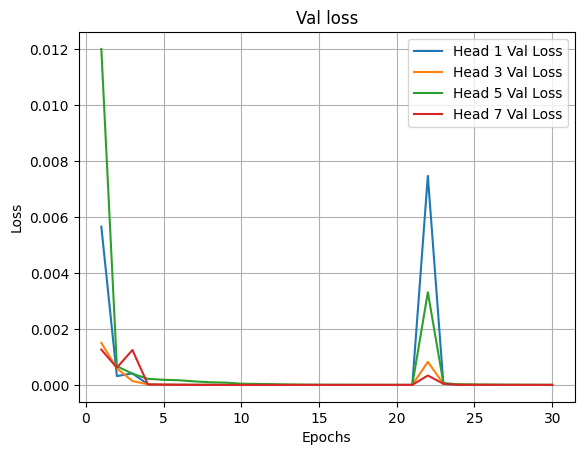

In [ ]:
epochs = range(1, len(history.history['val_dense_1_loss']) + 1)

for i in range(1, 8, 2):
    plt.plot(epochs, history.history[f'val_dense_{i}_loss'], label=f'Head {i} Val Loss')
plt.title('Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


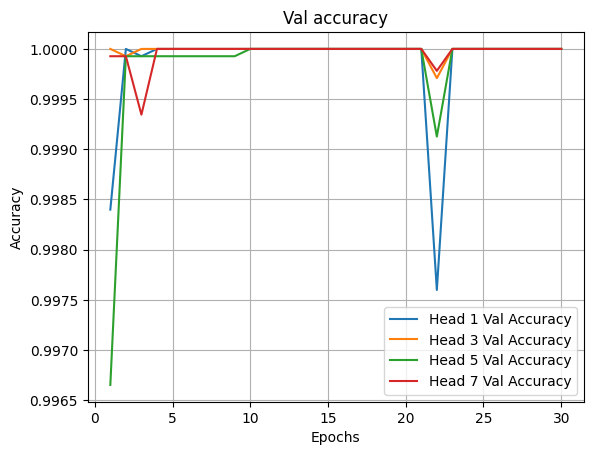

In [ ]:
for i in range(1, 8, 2):
    plt.plot(epochs, history.history[f'val_dense_{i}_accuracy'], label=f'Head {i} Val Accuracy')
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test)

430/430 ━━━━━━━━━━━━━━━━━━━━ 315s 734ms/step


In [ ]:
from sklearn import metrics
y_predss = [np.argmax(pred_prob, axis=1) for pred_prob in y_pred]

f1_scores = []
accuracy_scores = []
for i in range(4):
    y_val = [y_test[:, i] for i in range(y_test.shape[1])]
    y_true_labels = np.argmax(y_val[i], axis=1) if y_val[i].ndim > 1 else y_val[i]
    y_pred_labels = np.argmax(y_pred[i], axis=1)
    f1_scores.append(metrics.f1_score(y_true_labels, y_pred_labels, average='macro'))
    accuracy_scores.append(metrics.accuracy_score(y_true_labels, y_pred_labels))

print(sum(f1_scores) / len(f1_scores))
print(sum(accuracy_scores) / len(accuracy_scores))

1.0
[1.0, 1.0, 1.0, 1.0]


In [ ]:
!cp ./model_with_border.keras ./drive/MyDrive/Диплом/

## Старая апробация с MHAPooling

In [ ]:
@keras.saving.register_keras_serializable(package="MultiheadAttentionPoolingLayer")
class MultiheadAttentionPooling(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super(MultiheadAttentionPooling, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.multihead_attn = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=0.0
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x_reshaped = tf.reshape(inputs, (batch_size, self.embed_dim, -1))
        x_transposed = tf.transpose(x_reshaped, perm=[0, 2, 1])
        attn_output = self.multihead_attn(
            query=x_transposed,
            value=x_transposed,
            key=x_transposed
        )
        pooled = tf.reduce_mean(attn_output, axis=1)
        return pooled

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads
        })
        return config

In [ ]:
input_tensor_mha = keras.layers.Input(shape=(200,200,1))
x = keras.layers.Conv2D(4, (2, 2), activation='relu', padding='same')(input_tensor_mha)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(5, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(5, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(6, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(6, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.MaxPooling2D((2, 2))(x)
x = MultiheadAttentionPooling(embed_dim=200, num_heads=12)(x)
# x = keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.MaxPooling2D((2, 2))(x)
# x = keras.layers.Flatten()(x)

output_layers_mha = []
for _ in range(4):
    output = keras.layers.Dense(150, activation='relu')(x)
    output = keras.layers.Dense(10, activation='softmax')(output)
    output_layers_mha.append(output)

model_mha = keras.models.Model(inputs=input_tensor_mha, outputs=output_layers_mha)

In [ ]:
model_mha.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 200, 200, 4)    │             20 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 200, 200, 4)    │             16 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 200, 200, 4)    │             68 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 100, 100, 4)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 100, 100, 5)    │            185 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 100, 100, 5)    │             20 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 100, 100, 5)    │            230 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 50, 50, 5)      │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 50, 50, 6)      │            276 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 50, 50, 6)      │             24 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 6)      │            330 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multihead_attention_pool… │ (None, 200)            │      1,927,400 │ conv2d_11[0][0]        │
│ (MultiheadAttentionPooli… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 150)            │         30,150 │ multihead_attention_p… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 150)            │         30,150 │ multihead_attention_p… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 150)            │         30,150 │ multihead_attention_p… │
├──────────────────────

 Total params: 2,055,209 (7.84 MB)

 Trainable params: 2,055,179 (7.84 MB)

 Non-trainable params: 30 (120.00 B)

In [ ]:
model_mha.compile(optimizer=keras.optimizers.Nadam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    './model_mha.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

In [ ]:
history = model_mha.fit(X_train, [y_train[:, i] for i in range(4)],
                    callbacks=[checkpoint_cb],
                    validation_data=(X_test, [y_test[:, i] for i in range(4)]),
                    epochs=30)

Epoch 1/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dense_11_accuracy: 0.4993 - dense_11_loss: 1.2844 - dense_13_accuracy: 0.5423 - dense_13_loss: 1.2073 - dense_15_accuracy: 0.5458 - dense_15_loss: 1.1965 - dense_9_accuracy: 0.5168 - dense_9_loss: 1.2526 - loss: 4.9407
Epoch 1: val_loss improved from inf to 1.56667, saving model to ./model_mha.keras
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - dense_11_accuracy: 0.4994 - dense_11_loss: 1.2840 - dense_13_accuracy: 0.5424 - dense_13_loss: 1.2070 - dense_15_accuracy: 0.5459 - dense_15_loss: 1.1961 - dense_9_accuracy: 0.5170 - dense_9_loss: 1.2522 - loss: 4.9393 - val_dense_11_accuracy: 0.8566 - val_dense_11_loss: 0.3685 - val_dense_13_accuracy: 0.8576 - val_dense_13_loss: 0.3887 - val_dense_15_accuracy: 0.8693 - val_dense_15_loss: 0.3547 - val_dense_9_accuracy: 0.8280 - val_dense_9_loss: 0.4546 - val_loss: 1.5667
Epoch 2/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dense_11_accuracy: 0.8945 - dense_11_loss: 0.2915 - dense_13_a

In [ ]:
!cp ./model_mha.keras ./drive/MyDrive/Диплом/

## Загрузка модели

In [ ]:
# model = keras.saving.load_model('./drive/MyDrive/Диплом/model_mha.keras')
model = keras.saving.load_model('./drive/MyDrive/Диплом/model_with_border.keras')

In [ ]:
def recognition_pipeline(image, model):
    resized_img = cv2.resize(np.array(image), (200, 200),
                             interpolation=cv2.INTER_LANCZOS4)
    if resized_img.shape[-1] == 3:
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    pred = model.predict(np.array([resized_img]), verbose=0)
    return [np.argmax(output) for output in pred]


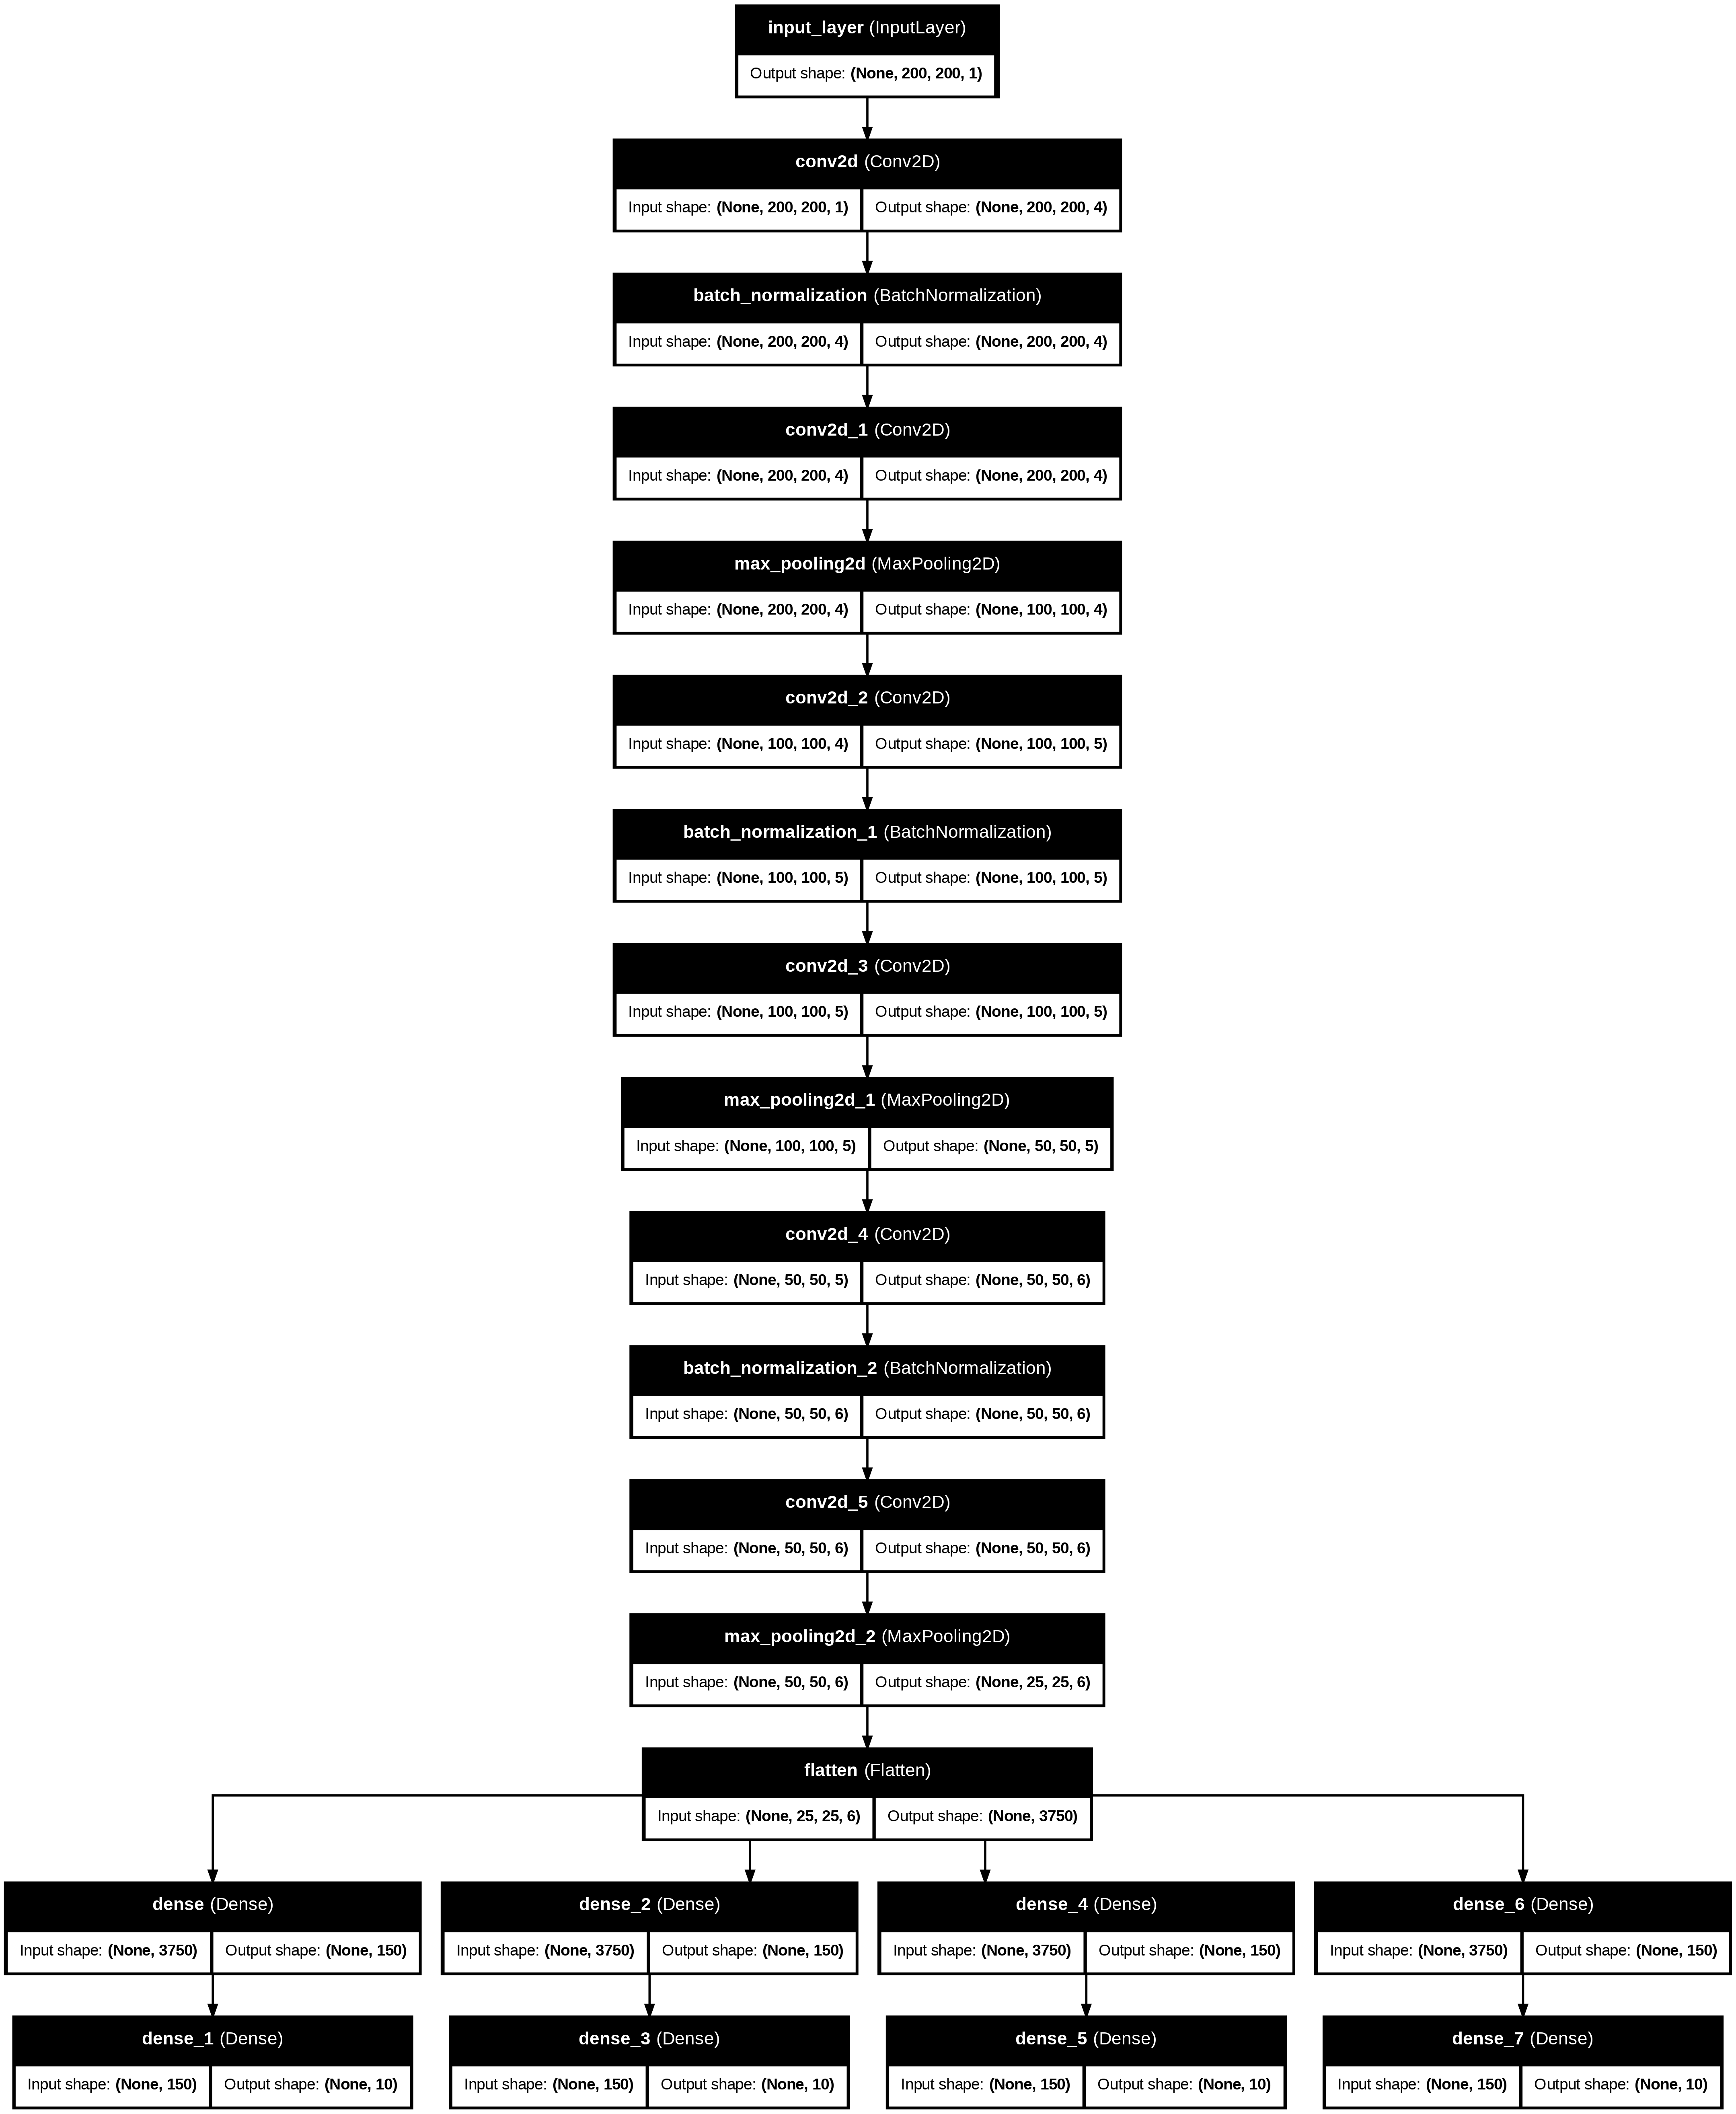

In [ ]:
keras.utils.plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

## Тестирование

In [ ]:
def crop_image(img_data):
    threshold = 100
    pixels_set = set()
    img_array = np.array(img_data)
    height, width, _ = img_array.shape
    for y in range(height):
        for x in range(width):
            r, g, b = img_array[y, x]
            if r < threshold and g < threshold and b > threshold:
                pixels_set.add((x, y))
    contours = []
    visited = set()
    for pixel in pixels_set:
        x, y = pixel
        key = (x, y)
        if key not in visited:
            contour = []
            stack = [(x, y)]
            visited.add(key)
            while stack:
                current_x, current_y = stack.pop()
                contour.append({'x': current_x, 'y': current_y})
                directions = [
                    (-1, 0),
                    (1, 0),
                    (0, -1),
                    (0, 1),
                ]
                for dx, dy in directions:
                    nx = current_x + dx
                    ny = current_y + dy
                    neighbor_key = (nx, ny)
                    if (0 <= nx < width and
                        0 <= ny < height and
                        neighbor_key in pixels_set and
                        neighbor_key not in visited):
                        visited.add(neighbor_key)
                        stack.append((nx, ny))
            contours.append(contour)
    largest_rectangle = None
    max_area = 0
    for contour in contours:
        min_x = min(point['x'] for point in contour)
        max_x = max(point['x'] for point in contour)
        min_y = min(point['y'] for point in contour)
        max_y = max(point['y'] for point in contour)
        width = max_x - min_x
        height = max_y - min_y
        area = width * height
        if area > max_area:
            max_area = area
            largest_rectangle = {'minX': min_x, 'minY': min_y, 'width': width, 'height': height}

    return largest_rectangle

In [ ]:
test_images = [np.array(Image.open(f'./test/{test_img_name}')) for test_img_name in os.listdir('./test')]
test_labels = [test_img_name.split('.')[0].split('_')[0] for test_img_name in os.listdir('./test')]

In [ ]:
preds = []
cropped_images = []
for test_img in test_images:
    c = crop_image(test_img)
    cropped_img = test_img[c['minY']: c['minY'] + c['height'], c['minX']: c['minX'] + c['width']]
    cropped_images.append(cropped_img)
    preds.append(''.join(list(map(str, recognition_pipeline(cropped_img, model)))))

In [ ]:
res = [1 if test_labels[i] == preds[i] else 0 for i in range(15)]
sum(res)

15

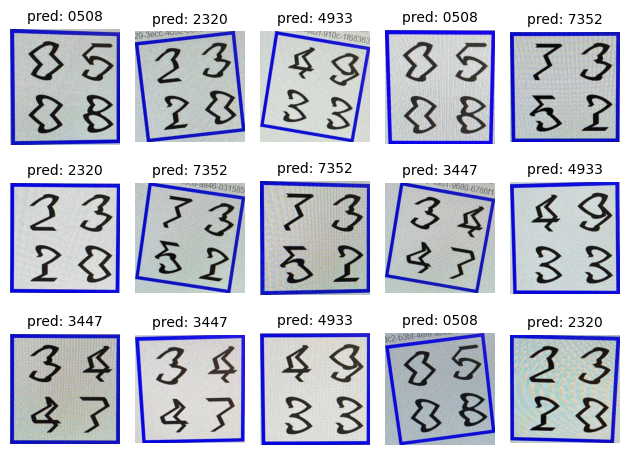

In [ ]:
fig, axes = plt.subplots(3, 5)
for i in range(15):
    axes[i % 3, i % 5].imshow(cropped_images[i])
    axes[i % 3, i % 5].set_title(f"pred: {preds[i]}", fontsize=10)
    axes[i % 3, i % 5].axis('off')
plt.tight_layout()
plt.show()

## Экспорт для tf js

In [ ]:
keras.saving.save_model(model, 'my_model.h5')

In [ ]:
tf.saved_model.save(model, './tf')

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found exi

In [ ]:
import tensorflowjs as tfjs

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    ./tf \
    ./tfjs

2025-03-21 13:39:43.740152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742564383.760078    4269 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742564383.766587    4269 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742564383.782378    4269 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742564383.782418    4269 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742564383.782422    4269 computation_placer.cc:177] computation placer alr

In [ ]:
!zip -r tfjs.zip ./tfjs

updating: tfjs/ (stored 0%)
  adding: tfjs/model.json (deflated 93%)
  adding: tfjs/group1-shard1of3.bin (deflated 7%)
  adding: tfjs/group1-shard3of3.bin (deflated 7%)
  adding: tfjs/group1-shard2of3.bin (deflated 7%)
